In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from keras import models
from keras.layers import Dense
import tensorflow as tf
from keras import models
import keras

ORDER_ASC = True; # Cambiar si es necesario ordenar los resultados de las pruebas ascendentemente o descendentemente

data_loc = Path('data/')
data_loc = data_loc / 'titanic.csv'

df = pd.read_csv(data_loc)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


Tras realizar un analisis de los datos, determinamos que las siguientes columnas no son necesarias para nuestro ejercicio:
- Fare: La tarifa del viaje se tacha de innecesaria debido a que ya tenemos las clases con la columna Pclass
- Cabin: No es realmente necesaria debido a la falta de información sobre las cabinas y hay muchos campos NaN
- Ticket: La id del ticket no es necesaria
- PassengerId: La id del pasajero no es necesario

In [2]:
df.drop(columns='Fare', inplace=True)
df.drop(columns='Cabin', inplace=True)
df.drop(columns='Ticket', inplace=True)
df.drop(columns='PassengerId', inplace=True)

- Mapeamos el sexo para que no sea string y damos valores a la columna de embarque

In [3]:
df['Sex'] = df['Sex'].apply(lambda x: 1 if x=='male' else 0)
df['Embarked'] = df['Embarked'].map({'S':3, 'Q':2, 'C':1})

- Hacemos limpieza de valores nan

In [4]:
df.dropna(inplace=True)

Con los nombres de los pasajeros podemos obtener el titulo de la persona obteniendo el texto que haya delante del punto. Con esto, conseguiremos que pasajeros tienen un titulo y determinaremos si los que tienen un titulo más valorado eran mas propensos a ser salvados

In [5]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df['Title'].value_counts() # Los valores Rev, Col, Dona y Dr seran irrelevantes debido a la cantidad de titulos que hay

Mr        183
Miss       64
Mrs        62
Master     17
Col         2
Rev         2
Dr          1
Dona        1
Name: Title, dtype: int64

In [6]:
df['Title'] = df['Title'].replace('Rev', 'Useless')
df['Title'] = df['Title'].replace('Col', 'Useless')
df['Title'] = df['Title'].replace('Dona', 'Useless')
df['Title'] = df['Title'].replace('Dr', 'Useless')

Haciendo la media, nos damos cuenta que el titulo de 'Mrs' tiene un 85% de posibilidades de salvarse, siguiéndole el titulo de 'Miss' con un 64%. Estos son unos valores que se deben de tener en cuenta y que son muy influentes a la hora de determinar si una persona va a sobrevivir o no

In [7]:
df[['Title', 'Survived']].groupby(['Title']).mean()

,Survived
Title,
Master,0.411765
Miss,0.640625
Mr,0.180328
Mrs,0.854839
Useless,0.500000


In [8]:
df.drop(columns='Name', inplace=True)

Realizamos un OneHotEncoder para determinar que pasajero tiene que titulo

In [9]:
from sklearn.preprocessing import OneHotEncoder

enc_ohe = OneHotEncoder(sparse=False)
enc_ohe.fit(df[['Title']])
data_encoder = enc_ohe.transform(df[['Title']])

featured_names = enc_ohe.get_feature_names(input_features=['Title'])
df_encoder = pd.DataFrame(data_encoder, columns = list(featured_names))

df = df.join(df_encoder)
df.drop(columns = ['Title'], inplace = True)

Datos finales con los que trabajaremos

In [10]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Useless
0,0,3,1,34.5,0,0,2,0.0,0.0,1.0,0.0,0.0
1,1,3,0,47.0,1,0,3,0.0,0.0,0.0,1.0,0.0
2,0,2,1,62.0,0,0,2,0.0,0.0,1.0,0.0,0.0
3,0,3,1,27.0,0,0,3,0.0,0.0,1.0,0.0,0.0
4,1,3,0,22.0,1,1,3,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
409,0,3,0,3.0,1,1,3,NaN,NaN,NaN,NaN,NaN
411,1,1,0,37.0,1,0,2,NaN,NaN,NaN,NaN,NaN
412,0,3,0,28.0,0,0,3,NaN,NaN,NaN,NaN,NaN
414,1,1,0,39.0,0,0,1,NaN,NaN,NaN,NaN,NaN


In [11]:
df.dropna(inplace=True)

Separamos el target en una variable diferente

In [12]:
target = df['Survived']

In [13]:
df.drop(columns='Survived', inplace=True)

Separamos los datos en train y test 

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

In [15]:
def get_model(neurons, activation = 'selu', optimizer = tf.keras.optimizers.Adam, lr = 0.001, dropout = 0, normalization = False, epochs = 15, seed = 5, return_precision = False):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    model = tf.keras.Sequential()
    
    model.add(Dense(neurons[0], activation=activation, input_dim=df.shape[1])) # Primera capa

    for index,neuron in enumerate(neurons[1:-1]): # Capas intermedias
            
        model.add(Dense(neuron, activation=activation))
        
        if dropout != 0:
            model.add(tf.keras.layers.Dropout(rate=dropout))

        if normalization:
            model.add(tf.keras.layers.BatchNormalization())

    model.add(Dense(neurons[-1], activation='sigmoid')) # Capa de salida

    model.compile(loss='mean_squared_error', optimizer=optimizer(learning_rate=lr), metrics=[tf.keras.metrics.Precision()])

    history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epochs, verbose=False)
    # print(history.history)
    if return_precision:
        return list(history.history.items())[3][1]
    else:
        return list(history.history.items())[0][1]


In [16]:
neurons = [
    [8,16,32,64,32,16,8,1],
    [8,16,8,4,1],
    [8,16,32,64,128,64,32,16,8,1],
    [8,16,32,16,8,4,1],
    [8,32,16,8,4,1],
    [2,4,8,16,8,4,1],
    [2,4,8,16,32,64,32,16,8,4,2,1],
    [2,4,8,16,32,16,8,4,2,1],
]

activations_hidden = [
    ('ReLu', 'relu'), 
    ('Tangente' , 'tanh'), 
    ('Leaky ReLU', tf.keras.layers.LeakyReLU()), 
    ('ELU','elu'), 
    ('SeLu','selu'), 
    ('GELU','gelu'), 
    ('Swish','swish'),
    ('Sigmoide', 'sigmoid')
]

optimizers = [
    tf.keras.optimizers.SGD, tf.keras.optimizers.Adam
]

learning_rate = [
    0.0001, 0.001, 0.01, 0.0005, 0.005, 0.05
]

dropout = [
    0, 0.01, 0.02, 0.2
]

epochs_list = [
    10,20,30,40,50
]

In [17]:
import matplotlib.pyplot as plt

def plot_metrics(axes, data, title):
    x = range(0, len(data))
    y = data
    axes = figure.add_subplot(6, 6, axes)
    axes.plot(x,y, color='black', label='loss')
    axes.set_xlabel('', fontsize=10)  
    axes.set_ylabel('Loss', fontsize=10)
    axes.set_title(f"{title}", fontsize=10)
    axes.legend(fontsize=8,facecolor='#CDCDCD')  

<h1>Redes

Modelo con la red [8, 16, 32, 64, 32, 16, 8, 1]: 0.2260313481092453
Modelo con la red [8, 16, 8, 4, 1]: 0.2459505796432495
Modelo con la red [8, 16, 32, 64, 128, 64, 32, 16, 8, 1]: 0.22197772562503815
Modelo con la red [8, 16, 32, 16, 8, 4, 1]: 0.22182804346084595
Modelo con la red [8, 32, 16, 8, 4, 1]: 0.23369523882865906
Modelo con la red [2, 4, 8, 16, 8, 4, 1]: 0.24128030240535736
Modelo con la red [2, 4, 8, 16, 32, 64, 32, 16, 8, 4, 2, 1]: 0.2421172708272934
Modelo con la red [2, 4, 8, 16, 32, 16, 8, 4, 2, 1]: 0.24140475690364838


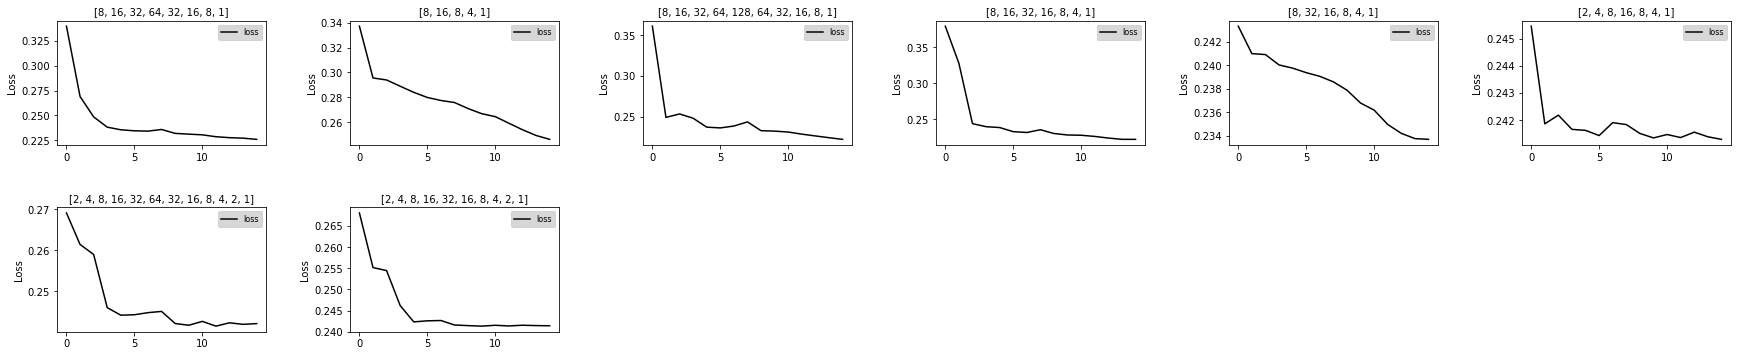

In [18]:
results = []
figure=plt.figure(figsize=[30,15])
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)

for index, neuron_layer in enumerate(neurons, start=1):
    precision = get_model(neuron_layer)
    results.append([neuron_layer, precision[-1]])
    print(f'Modelo con la red {neuron_layer}:',precision[-1])
    plot_metrics(index, precision, neuron_layer)


In [19]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=1, ascending=ORDER_ASC)
results_df

,0,1
3,"[8, 16, 32, 16, 8, 4, 1]",0.221828
2,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",0.221978
0,"[8, 16, 32, 64, 32, 16, 8, 1]",0.226031
4,"[8, 32, 16, 8, 4, 1]",0.233695
5,"[2, 4, 8, 16, 8, 4, 1]",0.241280
7,"[2, 4, 8, 16, 32, 16, 8, 4, 2, 1]",0.241405
6,"[2, 4, 8, 16, 32, 64, 32, 16, 8, 4, 2, 1]",0.242117
1,"[8, 16, 8, 4, 1]",0.245951


In [20]:
results = results_df[0:3].to_numpy()

<h1>Activaciones

Modelo con: 
-La red [8, 16, 32, 16, 8, 4, 1]
-La activación relu
Resultado: 0.24712514877319336 
Modelo con: 
-La red [8, 16, 32, 16, 8, 4, 1]
-La activación tanh
Resultado: 0.24102425575256348 
Modelo con: 
-La red [8, 16, 32, 16, 8, 4, 1]
-La activación <keras.layers.advanced_activations.LeakyReLU object at 0x0000020CBEF6A6A0>
Resultado: 0.22690656781196594 
Modelo con: 
-La red [8, 16, 32, 16, 8, 4, 1]
-La activación elu
Resultado: 0.22799377143383026 
Modelo con: 
-La red [8, 16, 32, 16, 8, 4, 1]
-La activación selu
Resultado: 0.22182804346084595 
Modelo con: 
-La red [8, 16, 32, 16, 8, 4, 1]
-La activación gelu
Resultado: 0.24598996341228485 
Modelo con: 
-La red [8, 16, 32, 16, 8, 4, 1]
-La activación swish
Resultado: 0.2377157062292099 
Modelo con: 
-La red [8, 16, 32, 16, 8, 4, 1]
-La activación sigmoid
Resultado: 0.2413090467453003 
Modelo con: 
-La red [8, 16, 32, 64, 128, 64, 32, 16, 8, 1]
-La activación relu
Resultado: 0.23905517160892487 
Modelo con: 
-La red [8, 16, 32, 

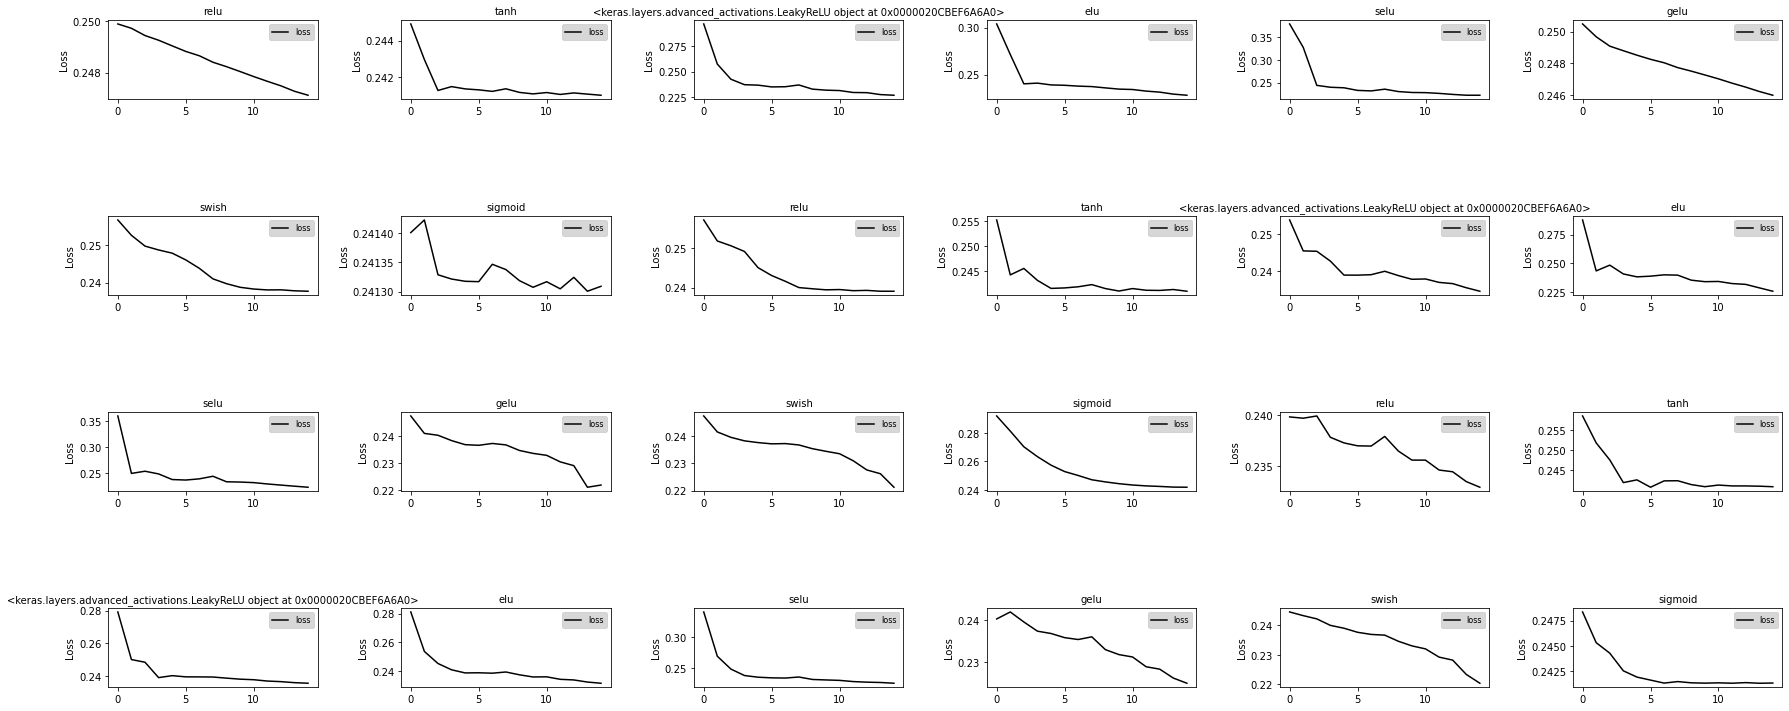

In [21]:
results_2 = []
figure=plt.figure(figsize=[30,15]) 
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
index = 0
for neuron_layer, value in results:
    index += 1
    for index, (activation_name, activation) in enumerate(activations_hidden, start=index):
        precision = get_model(neuron_layer, activation)
        print(f'Modelo con: \n-La red {neuron_layer}\n-La activación {activation}\nResultado:', precision[-1],'\n','='*40)
        results_2.append([neuron_layer, activation, precision[-1]])
        plot_metrics(index, precision, activation)

In [22]:
results_df = pd.DataFrame(results_2)
results_df = results_df.sort_values(by=2, ascending=ORDER_ASC)
results_df

,0,1,2
22,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,0.220424
14,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",swish,0.221210
13,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",gelu,0.221744
4,"[8, 16, 32, 16, 8, 4, 1]",selu,0.221828
12,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",selu,0.221978
21,"[8, 16, 32, 64, 32, 16, 8, 1]",gelu,0.224878
11,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",elu,0.225853
20,"[8, 16, 32, 64, 32, 16, 8, 1]",selu,0.226031
2,"[8, 16, 32, 16, 8, 4, 1]",<keras.layers.advanced_activations.LeakyReLU o...,0.226907
3,"[8, 16, 32, 16, 8, 4, 1]",elu,0.227994


In [23]:
results = results_df[0:3].to_numpy()

<h1>Optimizador</h1>
Con las gráficas, podemos observar que el optimizador adam tiene menos perturbaciones en sus resultados que el optimizador de descenso de gradiente

Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.gradient_descent.SGD'>
Resultado: 0.24624666571617126 
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Resultado: 0.22042395174503326 
Modelo con: 
-La red [8, 16, 32, 64, 128, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.gradient_descent.SGD'>
Resultado: 0.2557569146156311 
Modelo con: 
-La red [8, 16, 32, 64, 128, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Resultado: 0.22120988368988037 
Modelo con: 
-La red [8, 16, 32, 64, 128, 64, 32, 16, 8, 1]
-La activación gelu
-El optimizador <class 'keras.optimizer_v2.gradient_descent.SGD'>
Resultado: 0.2540161609649658 
Modelo con: 
-La red [8, 16, 32, 64, 128, 64, 32, 16, 8, 1]
-La activación gelu
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Resultado: 0.

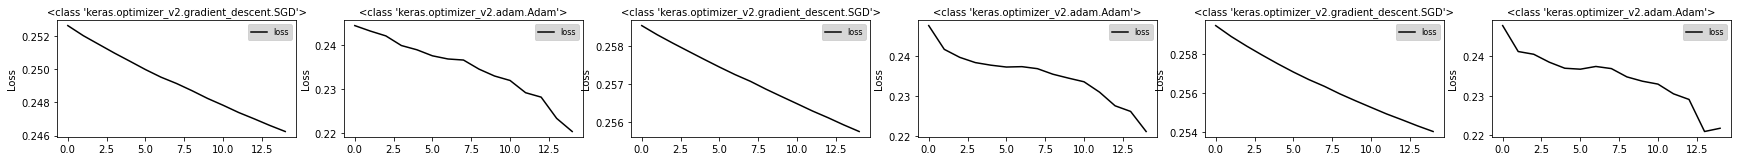

In [24]:
results_3 = []
figure=plt.figure(figsize=[30,15])
index = 0
for neuron_layer, activation, value in results:
    index += 1
    for index, optimizer in enumerate(optimizers, start=index):
            precision = get_model(neuron_layer, activation, optimizer)
            print(f'Modelo con: \n-La red {neuron_layer}\n-La activación {activation}\n-El optimizador {optimizer}\nResultado:', precision[-1],'\n','='*40)
            results_3.append([neuron_layer, activation, optimizer, precision[-1]])
            plot_metrics(index, precision, optimizer)

In [25]:
results_df = pd.DataFrame(results_3)
results_df = results_df.sort_values(by=3, ascending=ORDER_ASC)
results_df

,0,1,2,3
1,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.220424
3,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.221210
5,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",gelu,<class 'keras.optimizer_v2.adam.Adam'>,0.221744
0,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.gradient_descent.SGD'>,0.246247
4,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",gelu,<class 'keras.optimizer_v2.gradient_descent.SGD'>,0.254016
2,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.gradient_descent.SGD'>,0.255757


In [26]:
results = results_df[0:3].to_numpy()

<h1>Learning rate</h1>
Con las gráficas, podemos observar lo siguiente:

    - Los valores de 0.05 solo funcionan correctamente con los dos ultimos modelos
    - Los valores de 0.001 y 0.01 son muy similares en los 3 modelos 

Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.0001
Resultado: 0.23703578114509583 
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.001
Resultado: 0.22042395174503326 
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.01
Resultado: 0.20350581407546997 
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.0005
Resultado: 0.22830335795879364 
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.005
Resultado: 0.1883741319179535 
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <c

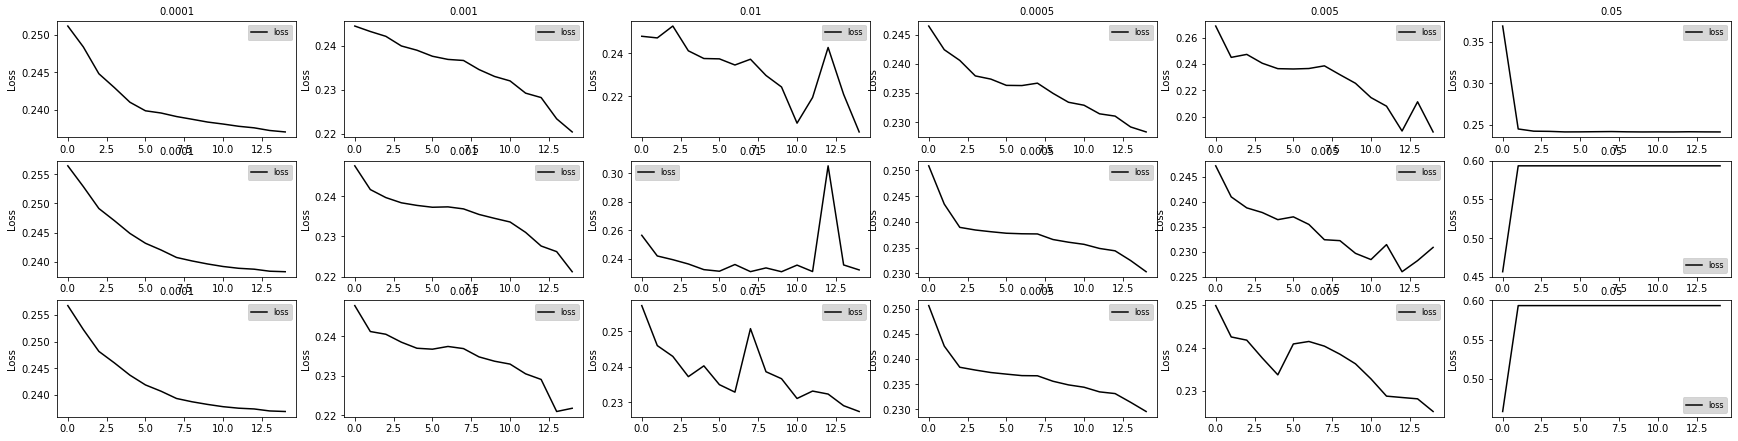

In [27]:
results_4 = []
figure=plt.figure(figsize=[30,15]) 
index = 0
for neuron_layer, activation, optimizer, value in results:
    index += 1
    for index, ln in enumerate(learning_rate, start=index):
            precision = get_model(neuron_layer, activation, optimizer, ln)
            print(f'Modelo con: \n-La red {neuron_layer}\n-La activación {activation}\n-El optimizador {optimizer}\nLearning Rate de {ln}\nResultado:', precision[-1],'\n','='*40)
            results_4.append([neuron_layer, activation, optimizer, ln, precision[-1]])
            plot_metrics(index, precision, ln)

In [28]:
results_df = pd.DataFrame(results_4)
results_df = results_df.sort_values(by=4, ascending=ORDER_ASC)
results_df

,0,1,2,3,4
4,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.0050,0.188374
2,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.0100,0.203506
1,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.0010,0.220424
7,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.0010,0.221210
13,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",gelu,<class 'keras.optimizer_v2.adam.Adam'>,0.0010,0.221744
16,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",gelu,<class 'keras.optimizer_v2.adam.Adam'>,0.0050,0.225134
14,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",gelu,<class 'keras.optimizer_v2.adam.Adam'>,0.0100,0.227372
3,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.0005,0.228303
15,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",gelu,<class 'keras.optimizer_v2.adam.Adam'>,0.0005,0.229578
9,"[8, 16, 32, 64, 128, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.0005,0.230299


In [29]:
results = results_df[0:3].to_numpy()

<h1>Dropdown</h1>

Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.005
Dropout 0
Resultado: 0.1883741319179535 
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.005
Dropout 0.01
Resultado: 0.19349905848503113 
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.005
Dropout 0.02
Resultado: 0.19249975681304932 
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.005
Dropout 0.2
Resultado: 0.24182221293449402 
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.01
Dropout 0
Resultado: 0.20350581407546997 
Modelo con: 
-La red [8, 16, 32, 6

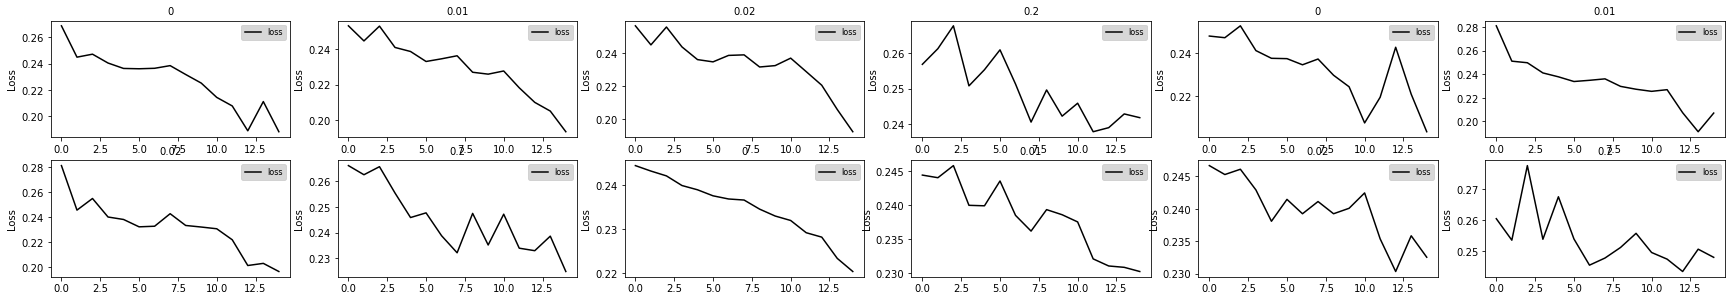

In [30]:
results_5 = []
figure=plt.figure(figsize=[30,15]) 
index = 0
for neuron_layer, activation, optimizer, ln, value in results:
    index += 1
    for index, dp in enumerate(dropout, start=index):
            precision = get_model(neuron_layer, activation, optimizer, ln, dp)
            print(f'Modelo con: \n-La red {neuron_layer}\n-La activación {activation}\n-El optimizador {optimizer}\nLearning Rate de {ln}\nDropout {dp}\nResultado:', precision[-1],'\n','='*40)
            results_5.append([neuron_layer, activation, optimizer, ln, dp, precision[-1]])
            plot_metrics(index, precision, dp)
            

In [31]:
results_df = pd.DataFrame(results_5)
results_df = results_df.sort_values(by=5, ascending=ORDER_ASC)
results_df

,0,1,2,3,4,5
0,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.00,0.188374
2,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.02,0.192500
1,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.01,0.193499
6,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.010,0.02,0.196317
4,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.010,0.00,0.203506
5,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.010,0.01,0.207106
8,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.001,0.00,0.220424
7,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.010,0.20,0.224912
9,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.001,0.01,0.230202
10,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.001,0.02,0.232551


In [32]:
results = results_df[0:3].to_numpy()

<h1>BatchNormalization</h1>

Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.005
Dropout 0.0
Resultado: 0.1353338658809662 
Con batchNormalization
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.005
Dropout 0.0
Resultado: 0.1883741319179535 
Sin batchNormalization
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.005
Dropout 0.02
Resultado: 0.1599646806716919 
Con batchNormalization
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.005
Dropout 0.02
Resultado: 0.19249975681304932 
Sin batchNormalization
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learni

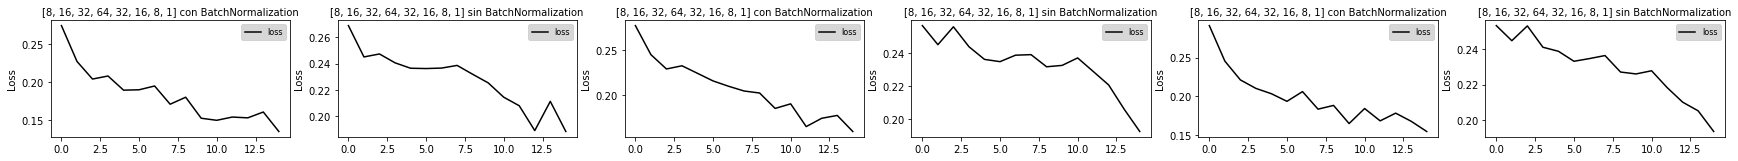

In [33]:
results_6 = []
figure=plt.figure(figsize=[30,15])
index = 1
for neuron_layer, activation, optimizer, ln, dp, value in results:
        precision = get_model(neuron_layer, activation, optimizer, ln, dp, True)
        print(f'Modelo con: \n-La red {neuron_layer}\n-La activación {activation}\n-El optimizador {optimizer}\nLearning Rate de {ln}\nDropout {dp}\nResultado:', precision[-1],'\nCon batchNormalization\n','='*40)
        results_6.append([neuron_layer, activation, optimizer, ln, dp, True, precision[-1]])
        plot_metrics(index, precision, f'{neuron_layer} con BatchNormalization')

        index += 1
        
        precision = get_model(neuron_layer, activation, optimizer, ln, dp, False)
        print(f'Modelo con: \n-La red {neuron_layer}\n-La activación {activation}\n-El optimizador {optimizer}\nLearning Rate de {ln}\nDropout {dp}\nResultado:', precision[-1],'\nSin batchNormalization\n','='*40)
        results_6.append([neuron_layer, activation, optimizer, ln, dp, False, precision[-1]])
        plot_metrics(index, precision, f'{neuron_layer} sin BatchNormalization')

        index += 1

In [34]:
results_df = pd.DataFrame(results_6)
results_df = results_df.sort_values(by=6, ascending=ORDER_ASC)
results_df

,0,1,2,3,4,5,6
0,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.00,True,0.135334
4,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.01,True,0.154505
2,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.02,True,0.159965
1,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.00,False,0.188374
3,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.02,False,0.192500
5,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.01,False,0.193499


In [35]:
results = results_df[0:3].to_numpy()

<h1>Épocas</h1>
Gracias a las gráficas, se puede observar que cuantas menos épocas, hay menos perturbaciones en los valores de pérdida

Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.005
Dropout 0.0
Tiene BatchNormalization: True
10 épocas
Resultado: 0.1526944488286972 
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.005
Dropout 0.0
Tiene BatchNormalization: True
20 épocas
Resultado: 0.15207281708717346 
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.005
Dropout 0.0
Tiene BatchNormalization: True
30 épocas
Resultado: 0.14938579499721527 
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activación swish
-El optimizador <class 'keras.optimizer_v2.adam.Adam'>
Learning Rate de 0.005
Dropout 0.0
Tiene BatchNormalization: True
40 épocas
Resultado: 0.14973711967468262 
Modelo con: 
-La red [8, 16, 32, 64, 32, 16, 8, 1]
-La activa

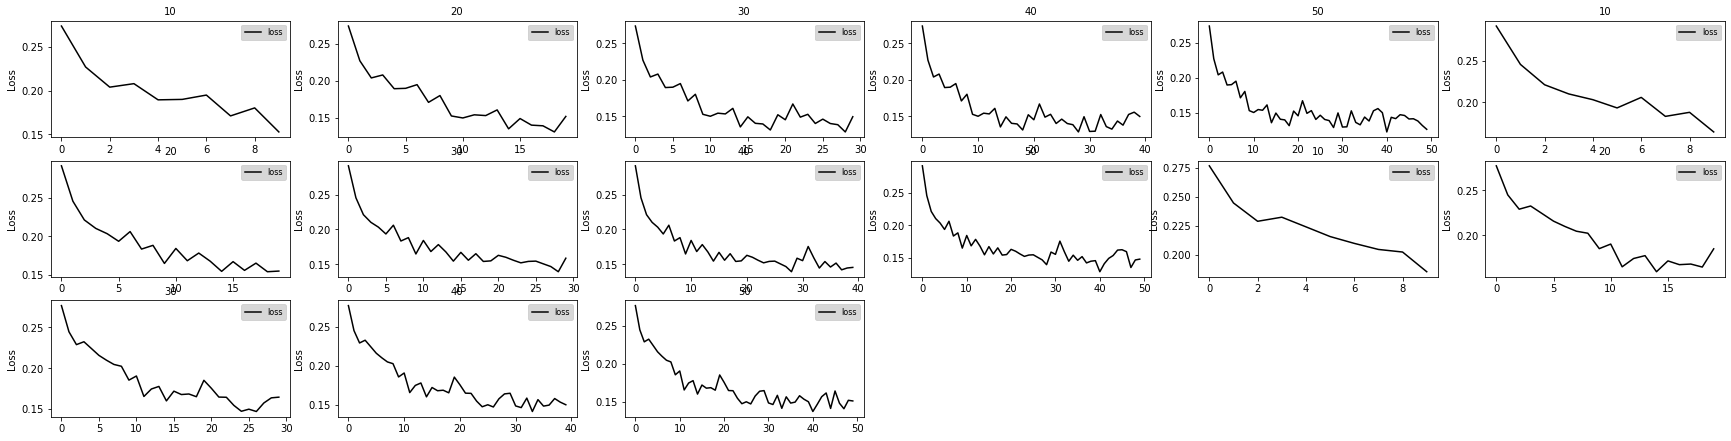

In [36]:
results_7 = []
figure=plt.figure(figsize=[30,15]) 
index = 0
for neuron_layer, activation, optimizer, ln, dp, batchNorm, value in results:
    index += 1
    for index, epochs in enumerate(epochs_list, start=index):
            precision = get_model(neuron_layer, activation, optimizer, ln, dp, batchNorm, epochs)
            print(f'Modelo con: \n-La red {neuron_layer}\n-La activación {activation}\n-El optimizador {optimizer}\nLearning Rate de {ln}\nDropout {dp}\nTiene BatchNormalization: {batchNorm}\n{epochs} épocas\nResultado:', precision[-1],'\n','='*40)
            results_7.append([neuron_layer, activation, optimizer, ln, dp, batchNorm, epochs, precision[-1]])
            plot_metrics(index, precision, epochs)

In [37]:
results_df = pd.DataFrame(results_7)
results_df = results_df.sort_values(by=7, ascending=ORDER_ASC)
results_df

,0,1,2,3,4,5,6,7
4,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.00,True,50,0.125879
8,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.01,True,40,0.145484
9,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.01,True,50,0.147819
2,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.00,True,30,0.149386
3,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.00,True,40,0.149737
13,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.02,True,40,0.149813
14,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.02,True,50,0.150904
1,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.00,True,20,0.152073
0,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.00,True,10,0.152694
6,"[8, 16, 32, 64, 32, 16, 8, 1]",swish,<class 'keras.optimizer_v2.adam.Adam'>,0.005,0.01,True,20,0.154867


In [38]:
results = results_df[0:3].to_numpy()

In [39]:
model_results = [[],[],[]]
for index, (neuron_layer, activation, optimizer, ln, dp, batchNorm, epochs, value) in enumerate(results):
    print(f'Modelo {index+1}: Empezando')
    for seed in range(1,51):
        value = get_model(neuron_layer, activation, optimizer, ln, dp, batchNorm, epochs, seed, True)
        model_results[index].append(value[-1])
        print(f'Semilla {seed}')

Modelo 1: Empezando
Semilla 1
Semilla 2
Semilla 3
Semilla 4
Semilla 5
Semilla 6
Semilla 7
Semilla 8
Semilla 9
Semilla 10
Semilla 11
Semilla 12
Semilla 13
Semilla 14
Semilla 15
Semilla 16
Semilla 17
Semilla 18
Semilla 19
Semilla 20
Semilla 21
Semilla 22
Semilla 23
Semilla 24
Semilla 25
Semilla 26
Semilla 27
Semilla 28
Semilla 29
Semilla 30
Semilla 31
Semilla 32
Semilla 33
Semilla 34
Semilla 35
Semilla 36
Semilla 37
Semilla 38
Semilla 39
Semilla 40
Semilla 41
Semilla 42
Semilla 43
Semilla 44
Semilla 45
Semilla 46
Semilla 47
Semilla 48
Semilla 49
Semilla 50
Modelo 2: Empezando
Semilla 1
Semilla 2
Semilla 3
Semilla 4
Semilla 5
Semilla 6
Semilla 7
Semilla 8
Semilla 9
Semilla 10
Semilla 11
Semilla 12
Semilla 13
Semilla 14
Semilla 15
Semilla 16
Semilla 17
Semilla 18
Semilla 19
Semilla 20
Semilla 21
Semilla 22
Semilla 23
Semilla 24
Semilla 25
Semilla 26
Semilla 27
Semilla 28
Semilla 29
Semilla 30
Semilla 31
Semilla 32
Semilla 33
Semilla 34
Semilla 35
Semilla 36
Semilla 37
Semilla 38
Semilla 39

- Como podemos ver, algunos resultados de las metricas dan 0 y 1, los cuales no son valores razonables. Una posible solución para arreglar este suceso podría ser la modificación de los datos 

In [40]:
model_results

[[0.44736841320991516,
  0.6451612710952759,
  1.0,
  0.6551724076271057,
  0.6296296119689941,
  0.75,
  0.6000000238418579,
  0.7333333492279053,
  0.8571428656578064,
  0.7333333492279053,
  0.5249999761581421,
  0.6153846383094788,
  0.6060606241226196,
  0.7777777910232544,
  0.6875,
  0.699999988079071,
  0.5357142686843872,
  0.5666666626930237,
  0.7894737124443054,
  0.5151515007019043,
  0.7222222089767456,
  0.6296296119689941,
  0.0,
  0.692307710647583,
  0.5555555820465088,
  0.6000000238418579,
  0.7333333492279053,
  1.0,
  0.8235294222831726,
  0.6666666865348816,
  0.5714285969734192,
  1.0,
  0.7058823704719543,
  0.800000011920929,
  0.6666666865348816,
  0.761904776096344,
  0.6842105388641357,
  0.375,
  1.0,
  0.6000000238418579,
  0.5925925970077515,
  0.5555555820465088,
  0.8125,
  0.7647058963775635,
  1.0,
  0.800000011920929,
  0.7142857313156128,
  0.5277777910232544,
  0.5652173757553101,
  0.6000000238418579],
 [0.800000011920929,
  0.7368420958518982,
 

# Grafica de metricas de precisión en los tres modelos

Según la grafica, el segundo modelo contiene unos valores de la metrica de precisión menos dispersos, aunque cuenta con algunos valores que tienen una gran diferencia con el conjunto, representados con unas bolitas

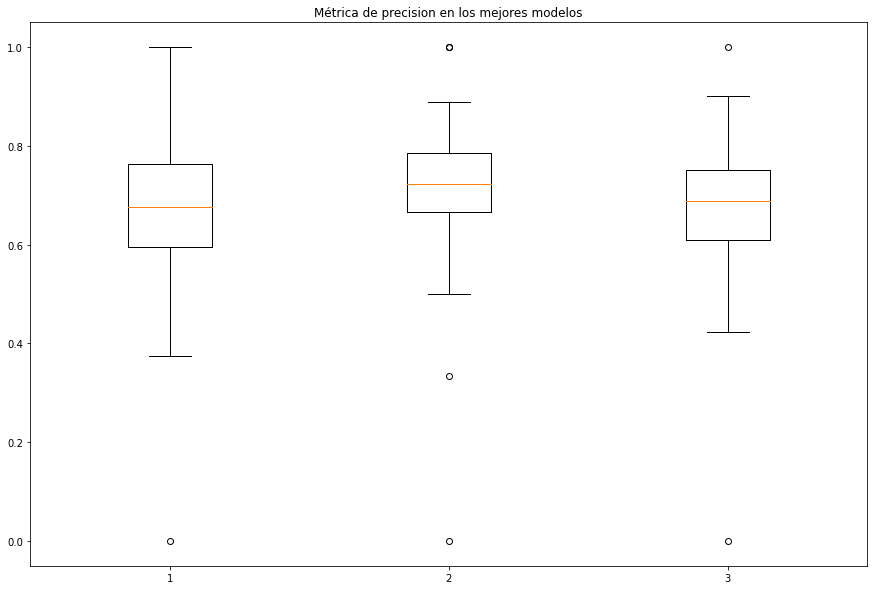

In [41]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
ax.set_title('Métrica de precision en los mejores modelos')
ax.boxplot(model_results)
plt.show()